In [1]:
#!pip install TSAI
import numpy as np
import pandas as pd
from tsai.all import *
from sklearn.preprocessing import StandardScaler

# Cargar el dataset
df_frames = pd.read_csv("dataframe_frames.csv")

# Selección de Características
features = [
    'center_x', 'center_y',
    'width', 'height',
    'bbox_area',
    'movement_since_last_frame',
    'confidence',
    'distance_from_center',
    'total_persons_in_frame'
]

scaler = StandardScaler()
df_frames[features] = scaler.fit_transform(df_frames[features])

# Agrupamos por 'video_folder' y 'person_id' para crear una secuencia
# única para cada persona en cada video.
X_list, y_list = [], []
for (video, person), group in df_frames.groupby(['video_folder', 'person_id']):
    if len(group) < 10:
        continue

    # Usamos .to_numpy() para garantizar que obtenemos un array de NumPy
    sequence = group[features].to_numpy().T
    X_list.append(sequence)
    y_list.append(group['label'].iloc[0])

# Unificar la longitud de las secuencias con padding
X_padded = pad_sequences(X_list, padding='post', truncating='post')

# Convertir a arrays de NumPy y codificar etiquetas
X = np.array(X_padded)
y, classes = pd.factorize(np.array(y_list))

print(f"\nForma final del array de datos (X): {X.shape}")
print(f"Clases: {classes}")
print(f"Total de secuencias de personas a analizar: {len(X)}")


Forma final del array de datos (X): (2899, 9, 10)
Clases: ['anomaly' 'normal']
Total de secuencias de personas a analizar: 2899


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.586726,0.586075,0.666667,0.665225,0.690719,00:19
1,0.544535,0.556721,0.701209,0.699776,0.726494,00:20
2,0.520615,0.535839,0.702936,0.701718,0.729647,00:18
3,0.501474,0.521657,0.713299,0.710081,0.730084,00:20
4,0.486839,0.518850,0.727116,0.722708,0.739466,00:19
5,0.485072,0.512742,0.747841,0.742016,0.755299,00:19
6,0.471423,0.497668,0.739206,0.733868,0.748335,00:20
7,0.461684,0.500091,0.728843,0.726966,0.752298,00:19
8,0.450534,0.513031,0.715026,0.713920,0.742916,00:19
9,0.442165,0.482732,0.759931,0.755017,0.770328,00:20


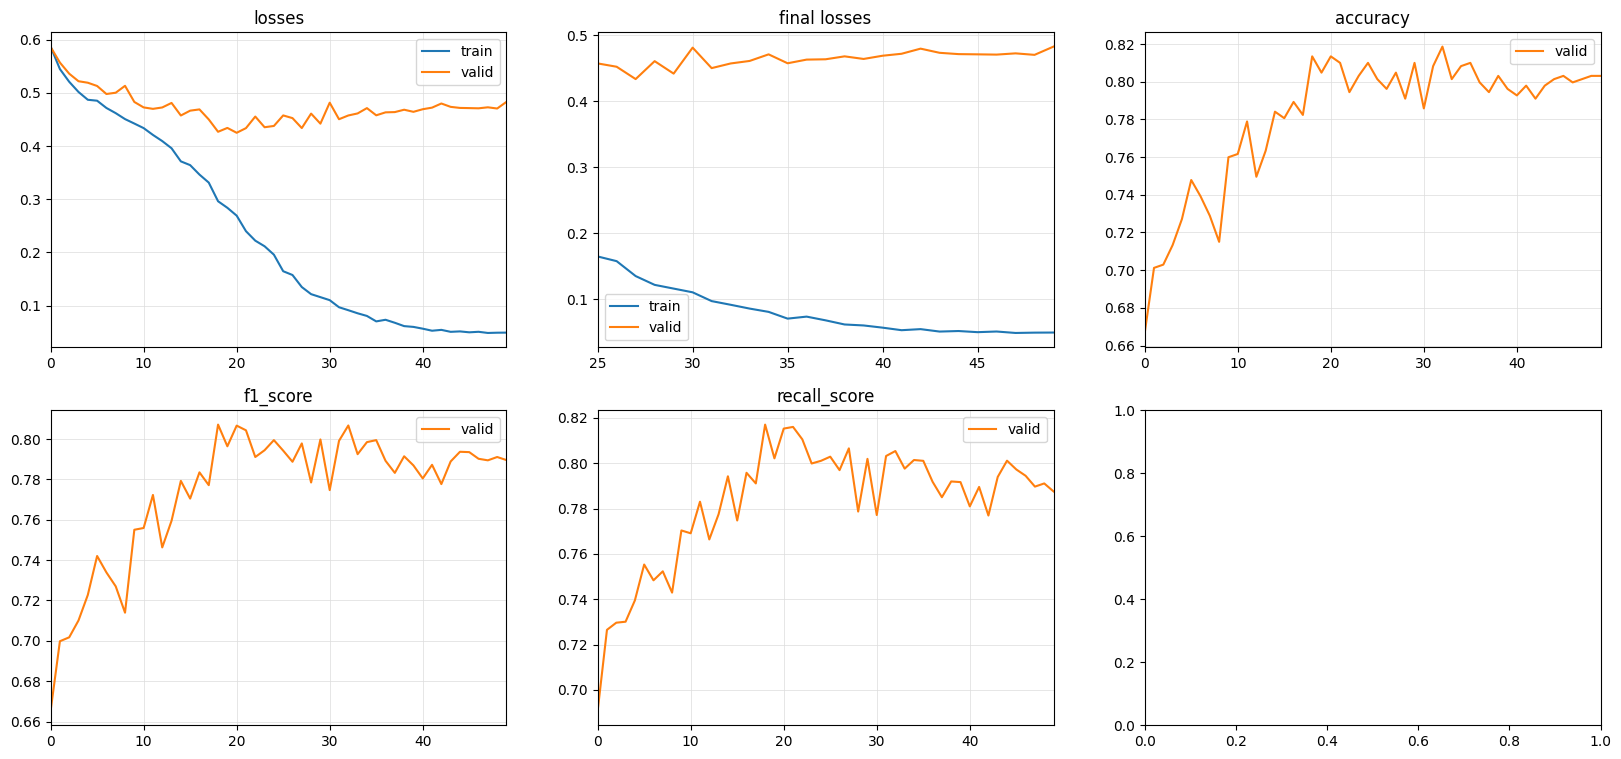

Distribución de clases: (array([0, 1]), array([220, 359]))

=== MÉTRICAS CLASE ANORMAL (1) ===
Recall clase anormal: 0.8524
F1-Score clase anormal: 0.8430
Precisión clase anormal: 0.8338

=== MATRIZ DE CONFUSIÓN ===
Matriz de confusión numérica:
[[159  61]
 [ 53 306]]


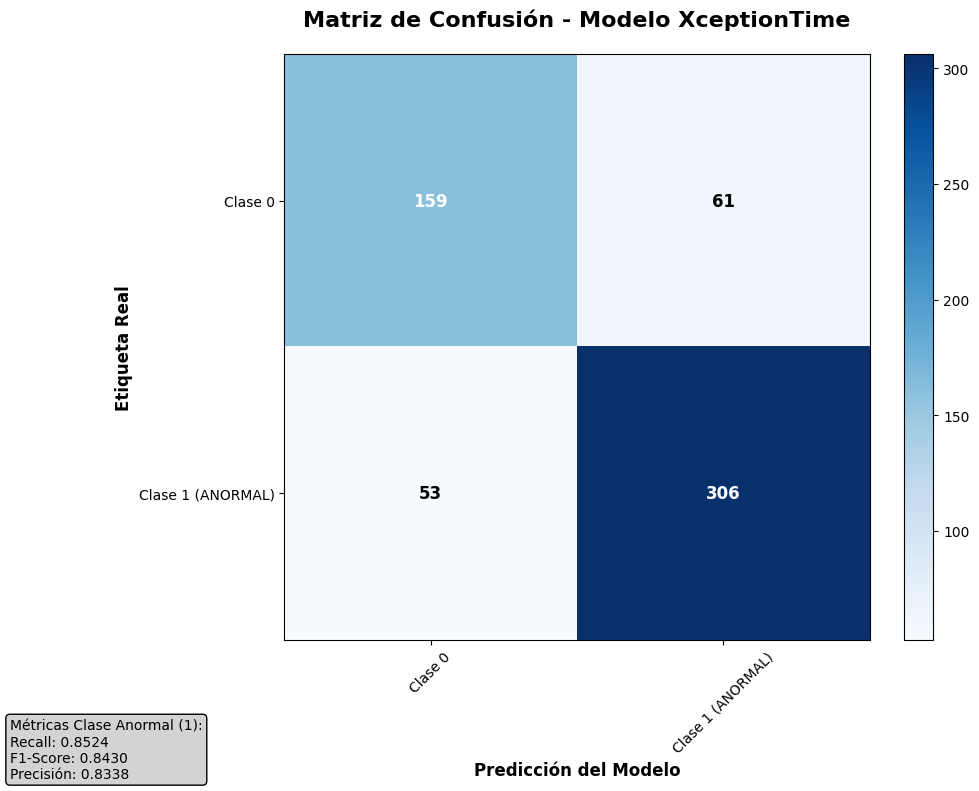


=== REPORTE DE CLASIFICACIÓN COMPLETO ===
              precision    recall  f1-score   support

           0       0.75      0.72      0.74       220
           1       0.83      0.85      0.84       359

    accuracy                           0.80       579
   macro avg       0.79      0.79      0.79       579
weighted avg       0.80      0.80      0.80       579


=== MÉTRICAS GLOBALES ===
Accuracy global: 0.8031
F1-Score macro: 0.7895
Recall macro: 0.7875

=== INFORMACIÓN CLASE ANORMAL (1) ===
Total muestras anormales en test: 359
Predichas como anormales: 367
Correctamente clasificadas como anormales: 306
Falsos positivos: 61
Falsos negativos: 53


In [23]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
from tsai.all import *
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

# 1) Calcular pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = class_weights.to(device)

# 2) Crear splits
indices = np.arange(len(X))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y)
splits = [train_idx, test_idx]

# 3) DataLoaders
dls = TSDataLoaders.from_numpy(X, y, splits=splits, bs=32)

# 4) Modelo
model = XceptionTime(9, dls.c).to(device)

# 5) Definir loss con pesos de clase
loss_fn = CrossEntropyLoss(weight=class_weights)

# 6) Crear Learner
learn = Learner(dls, model, loss_func=loss_fn,
                metrics=[accuracy, F1Score(average='macro'), Recall(average='macro')])

learn.fit_one_cycle(50, lr_max=1e-3)
learn.plot_metrics()

probs, targets = learn.get_preds()
preds = probs.argmax(dim=1)

targets_np = targets.cpu().numpy()
preds_np = preds.cpu().numpy()

clase_anormal = 1

print(f"Distribución de clases: {np.unique(targets_np, return_counts=True)}")

print(f"\n=== MÉTRICAS CLASE ANORMAL ({clase_anormal}) ===")
recall_anormal = recall_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]
f1_anormal = f1_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]
precision_anormal = precision_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]

print(f"Recall clase anormal: {recall_anormal:.4f}")
print(f"F1-Score clase anormal: {f1_anormal:.4f}")
print(f"Precisión clase anormal: {precision_anormal:.4f}")

print(f"\n=== MATRIZ DE CONFUSIÓN ===")
cm = confusion_matrix(targets_np, preds_np)
print("Matriz de confusión numérica:")
print(cm)

plt.figure(figsize=(10, 8))
im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Modelo XceptionTime', fontsize=16, fontweight='bold', pad=20)
plt.colorbar(im, fraction=0.046, pad=0.04)

tick_marks = np.arange(len(np.unique(targets_np)))
class_labels = [f'Clase {i}' for i in range(len(np.unique(targets_np)))]
class_labels[clase_anormal] = f'Clase {clase_anormal} (ANORMAL)'

plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12,
                fontweight='bold')

plt.ylabel('Etiqueta Real', fontsize=12, fontweight='bold')
plt.xlabel('Predicción del Modelo', fontsize=12, fontweight='bold')
plt.tight_layout()

plt.figtext(0.02, 0.02,
           f"Métricas Clase Anormal ({clase_anormal}):\n"
           f"Recall: {recall_anormal:.4f}\n"
           f"F1-Score: {f1_anormal:.4f}\n"
           f"Precisión: {precision_anormal:.4f}",
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"),
           fontsize=10)

plt.show()

print(f"\n=== REPORTE DE CLASIFICACIÓN COMPLETO ===")
report = classification_report(targets_np, preds_np)
print(report)

print(f"\n=== MÉTRICAS GLOBALES ===")
accuracy_global = (targets_np == preds_np).mean()
print(f"Accuracy global: {accuracy_global:.4f}")

f1_macro = f1_score(targets_np, preds_np, average='macro')
print(f"F1-Score macro: {f1_macro:.4f}")

recall_macro = recall_score(targets_np, preds_np, average='macro')
print(f"Recall macro: {recall_macro:.4f}")

print(f"\n=== INFORMACIÓN CLASE ANORMAL ({clase_anormal}) ===")
total_anormal = (targets_np == clase_anormal).sum()
predichos_anormal = (preds_np == clase_anormal).sum()
correctos_anormal = ((targets_np == clase_anormal) & (preds_np == clase_anormal)).sum()

print(f"Total muestras anormales en test: {total_anormal}")
print(f"Predichas como anormales: {predichos_anormal}")
print(f"Correctamente clasificadas como anormales: {correctos_anormal}")
print(f"Falsos positivos: {predichos_anormal - correctos_anormal}")
print(f"Falsos negativos: {total_anormal - correctos_anormal}")

Implementación de InceptionTime

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.553867,0.568308,0.711572,0.699939,00:10
1,0.485394,0.517148,0.746114,0.736962,00:10
2,0.438442,0.482179,0.782383,0.766950,00:10
3,0.405405,0.569906,0.749568,0.740884,00:09
4,0.387798,0.544828,0.754750,0.728832,00:10
5,0.365032,0.552268,0.761658,0.745236,00:10
6,0.347499,0.619724,0.732297,0.725363,00:10
7,0.339503,0.641059,0.747841,0.714828,00:11
8,0.325325,0.645260,0.723661,0.670264,00:09
9,0.307439,0.724974,0.768566,0.748646,00:11


Distribución de clases en test: (array([0, 1]), array([234, 346]))

=== MÉTRICAS CLASE ANORMAL (1) ===
Recall clase anormal: 0.9364
F1-Score clase anormal: 0.9543
Precisión clase anormal: 0.9730

=== MATRIZ DE CONFUSIÓN ===
Matriz de confusión numérica:
[[225   9]
 [ 22 324]]


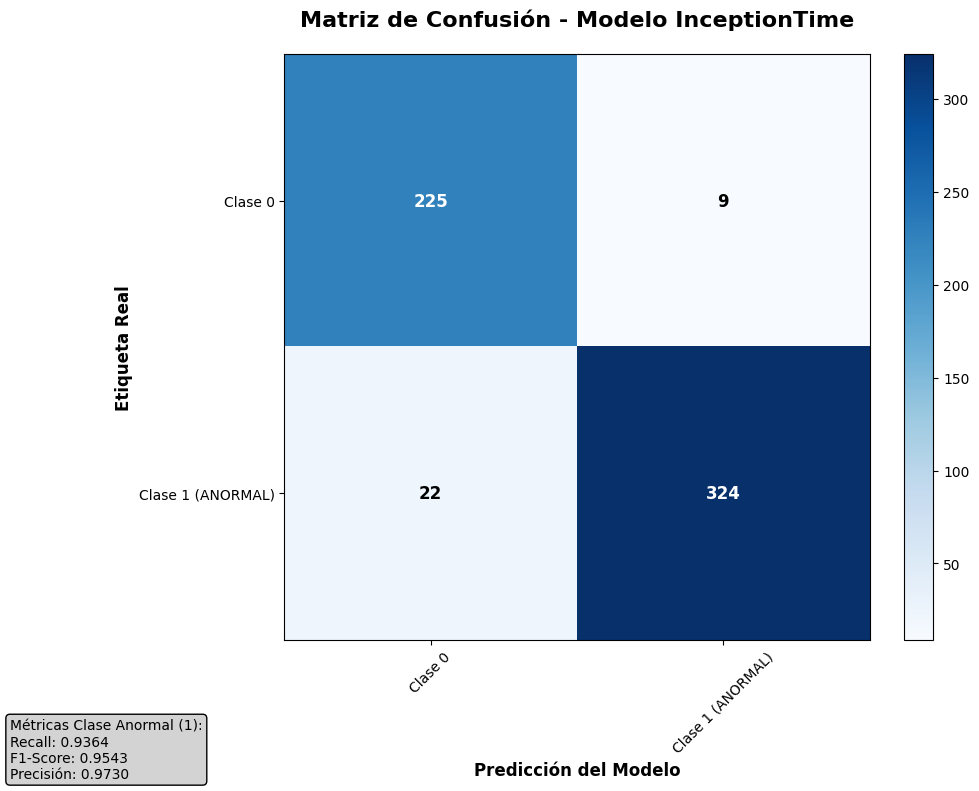


### Reporte de Clasificación del Modelo InceptionTime ###
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       234
           1       0.97      0.94      0.95       346

    accuracy                           0.95       580
   macro avg       0.94      0.95      0.94       580
weighted avg       0.95      0.95      0.95       580


=== MÉTRICAS GLOBALES ===
Accuracy global: 0.9466
F1-Score macro: 0.9449
Recall macro: 0.9490

=== INFORMACIÓN CLASE ANORMAL (1) ===
Total muestras anormales en test: 346
Predichas como anormales: 333
Correctamente clasificadas como anormales: 324
Falsos positivos: 9
Falsos negativos: 22


In [22]:
from tsai.all import *
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Crear los DataLoaders
dls = TSDataLoaders.from_numpy(X, y, splits=splits, bs=32)

# 2. Instanciar la arquitectura del modelo InceptionTime
model = InceptionTime(9, dls.c)

# 3. Crear el 'Learner'
learn = Learner(dls, model, metrics=[accuracy, F1Score(average='macro')])

# 4. Entrenar el modelo
learn.fit_one_cycle(50, lr_max=1e-3)

# 5. Evaluación final
test_dl = dls.test_dl(X[test_idx])
probas, _, preds = learn.get_preds(dl=test_dl, with_decoded=True)

preds_np = preds.numpy()
targets_np = y[test_idx]

clase_anormal = 1

print(f"Distribución de clases en test: {np.unique(targets_np, return_counts=True)}")

print(f"\n=== MÉTRICAS CLASE ANORMAL ({clase_anormal}) ===")
recall_anormal = recall_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]
f1_anormal = f1_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]
precision_anormal = precision_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]

print(f"Recall clase anormal: {recall_anormal:.4f}")
print(f"F1-Score clase anormal: {f1_anormal:.4f}")
print(f"Precisión clase anormal: {precision_anormal:.4f}")

print(f"\n=== MATRIZ DE CONFUSIÓN ===")
cm = confusion_matrix(targets_np, preds_np)
print("Matriz de confusión numérica:")
print(cm)

plt.figure(figsize=(10, 8))
im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Modelo InceptionTime', fontsize=16, fontweight='bold', pad=20)
plt.colorbar(im, fraction=0.046, pad=0.04)

tick_marks = np.arange(len(np.unique(targets_np)))
class_labels = [f'Clase {i}' for i in range(len(np.unique(targets_np)))]
class_labels[clase_anormal] = f'Clase {clase_anormal} (ANORMAL)'

plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12,
                fontweight='bold')

plt.ylabel('Etiqueta Real', fontsize=12, fontweight='bold')
plt.xlabel('Predicción del Modelo', fontsize=12, fontweight='bold')
plt.tight_layout()

plt.figtext(0.02, 0.02,
           f"Métricas Clase Anormal ({clase_anormal}):\n"
           f"Recall: {recall_anormal:.4f}\n"
           f"F1-Score: {f1_anormal:.4f}\n"
           f"Precisión: {precision_anormal:.4f}",
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"),
           fontsize=10)

plt.show()

print("\n### Reporte de Clasificación del Modelo InceptionTime ###")
print(classification_report(targets_np, preds_np))

print(f"\n=== MÉTRICAS GLOBALES ===")
accuracy_global = (targets_np == preds_np).mean()
print(f"Accuracy global: {accuracy_global:.4f}")

f1_macro = f1_score(targets_np, preds_np, average='macro')
print(f"F1-Score macro: {f1_macro:.4f}")

recall_macro = recall_score(targets_np, preds_np, average='macro')
print(f"Recall macro: {recall_macro:.4f}")

print(f"\n=== INFORMACIÓN CLASE ANORMAL ({clase_anormal}) ===")
total_anormal = (targets_np == clase_anormal).sum()
predichos_anormal = (preds_np == clase_anormal).sum()
correctos_anormal = ((targets_np == clase_anormal) & (preds_np == clase_anormal)).sum()

print(f"Total muestras anormales en test: {total_anormal}")
print(f"Predichas como anormales: {predichos_anormal}")
print(f"Correctamente clasificadas como anormales: {correctos_anormal}")
print(f"Falsos positivos: {predichos_anormal - correctos_anormal}")
print(f"Falsos negativos: {total_anormal - correctos_anormal}")

Implementación con MiniRocket

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.569738,0.576799,0.692573,0.686123,00:03
1,0.526864,0.631312,0.682211,0.679726,00:05
2,0.498533,0.591684,0.701209,0.690847,00:02
3,0.494867,0.608983,0.701209,0.682655,00:02
4,0.522204,0.720865,0.687392,0.667980,00:03
5,0.534108,0.847089,0.692573,0.675987,00:03
6,0.520891,0.809772,0.692573,0.677544,00:02
7,0.525708,0.879466,0.680484,0.662966,00:02
8,0.574415,1.100945,0.618307,0.598044,00:02
9,0.601459,1.102286,0.675302,0.659429,00:03


Distribución de clases: (array([0, 1]), array([220, 359]))

=== MÉTRICAS CLASE ANORMAL (1) ===
Recall clase anormal: 0.7214
F1-Score clase anormal: 0.7255
Precisión clase anormal: 0.7296

=== MATRIZ DE CONFUSIÓN ===
Matriz de confusión numérica:
[[124  96]
 [100 259]]


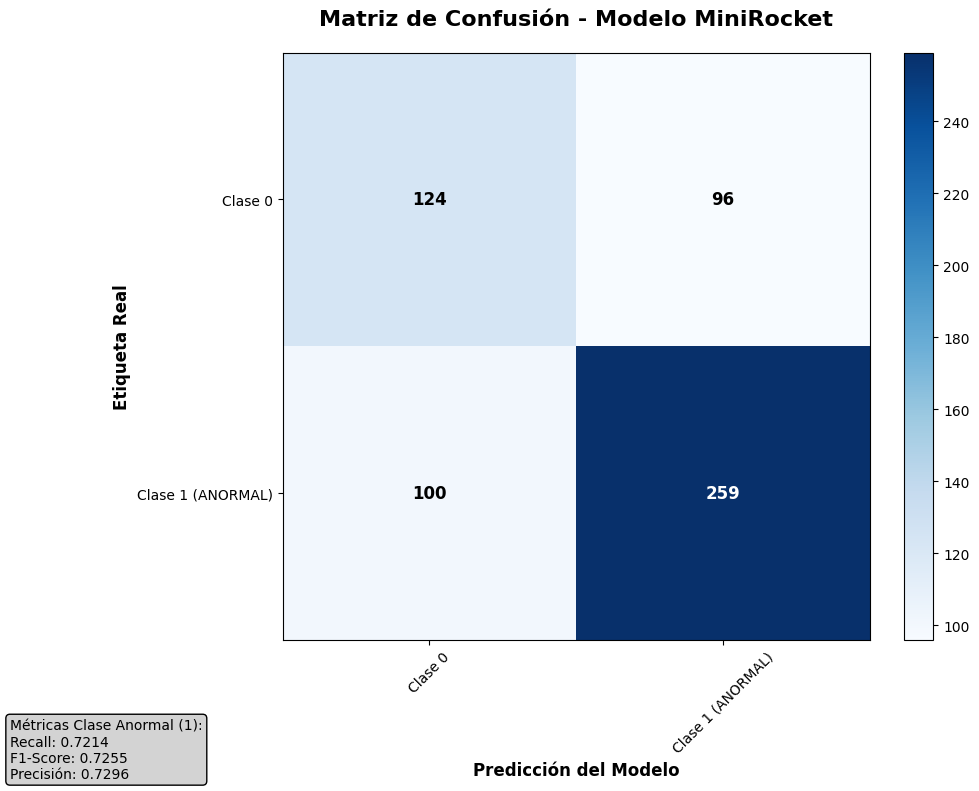


### Reporte de Clasificación del Modelo MiniRocket ###
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       220
           1       0.73      0.72      0.73       359

    accuracy                           0.66       579
   macro avg       0.64      0.64      0.64       579
weighted avg       0.66      0.66      0.66       579


=== MÉTRICAS GLOBALES ===
Accuracy global: 0.6615
F1-Score macro: 0.6420
Recall macro: 0.6425

=== INFORMACIÓN CLASE ANORMAL (1) ===
Total muestras anormales en test: 359
Predichas como anormales: 355
Correctamente clasificadas como anormales: 259
Falsos positivos: 96
Falsos negativos: 100


In [21]:
from tsai.all import *
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Crear los DataLoaders
dls = TSDataLoaders.from_numpy(X, y, splits=splits, bs=32)

# 2. Instanciar MiniRocket (forma alternativa)
try:
    model = MiniRocket(9, dls.c, seq_len=X.shape[2])
except:
    model = MiniRocket(9, dls.c)

# 3. Crear el 'Learner'
learn = Learner(dls, model, metrics=[accuracy, F1Score(average='macro')])

# 4. Entrenar el modelo
learn.fit_one_cycle(50, lr_max=1e-3)

# 5. Obtener predicciones de forma robusta
probs, targets = learn.get_preds()
preds = probs.argmax(dim=1)

preds_np = preds.cpu().numpy()
targets_np = targets.cpu().numpy()

clase_anormal = 1

print(f"Distribución de clases: {np.unique(targets_np, return_counts=True)}")

print(f"\n=== MÉTRICAS CLASE ANORMAL ({clase_anormal}) ===")
recall_anormal = recall_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]
f1_anormal = f1_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]
precision_anormal = precision_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]

print(f"Recall clase anormal: {recall_anormal:.4f}")
print(f"F1-Score clase anormal: {f1_anormal:.4f}")
print(f"Precisión clase anormal: {precision_anormal:.4f}")

print(f"\n=== MATRIZ DE CONFUSIÓN ===")
cm = confusion_matrix(targets_np, preds_np)
print("Matriz de confusión numérica:")
print(cm)

plt.figure(figsize=(10, 8))
im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Modelo MiniRocket', fontsize=16, fontweight='bold', pad=20)
plt.colorbar(im, fraction=0.046, pad=0.04)

tick_marks = np.arange(len(np.unique(targets_np)))
class_labels = [f'Clase {i}' for i in range(len(np.unique(targets_np)))]
class_labels[clase_anormal] = f'Clase {clase_anormal} (ANORMAL)'

plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12,
                fontweight='bold')

plt.ylabel('Etiqueta Real', fontsize=12, fontweight='bold')
plt.xlabel('Predicción del Modelo', fontsize=12, fontweight='bold')
plt.tight_layout()

plt.figtext(0.02, 0.02,
           f"Métricas Clase Anormal ({clase_anormal}):\n"
           f"Recall: {recall_anormal:.4f}\n"
           f"F1-Score: {f1_anormal:.4f}\n"
           f"Precisión: {precision_anormal:.4f}",
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"),
           fontsize=10)

plt.show()

print("\n### Reporte de Clasificación del Modelo MiniRocket ###")
print(classification_report(targets_np, preds_np))

print(f"\n=== MÉTRICAS GLOBALES ===")
accuracy_global = (targets_np == preds_np).mean()
print(f"Accuracy global: {accuracy_global:.4f}")

f1_macro = f1_score(targets_np, preds_np, average='macro')
print(f"F1-Score macro: {f1_macro:.4f}")

recall_macro = recall_score(targets_np, preds_np, average='macro')
print(f"Recall macro: {recall_macro:.4f}")

print(f"\n=== INFORMACIÓN CLASE ANORMAL ({clase_anormal}) ===")
total_anormal = (targets_np == clase_anormal).sum()
predichos_anormal = (preds_np == clase_anormal).sum()
correctos_anormal = ((targets_np == clase_anormal) & (preds_np == clase_anormal)).sum()

print(f"Total muestras anormales en test: {total_anormal}")
print(f"Predichas como anormales: {predichos_anormal}")
print(f"Correctamente clasificadas como anormales: {correctos_anormal}")
print(f"Falsos positivos: {predichos_anormal - correctos_anormal}")
print(f"Falsos negativos: {total_anormal - correctos_anormal}")

Implementación con XCM

Entrenando XCM con 50 epochs...


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.647650,0.616478,0.696028,0.665467,00:03
1,0.572418,0.566006,0.709845,0.688063,00:05
2,0.518470,0.523172,0.739206,0.722011,00:03
3,0.479512,0.506426,0.751295,0.737877,00:04
4,0.454748,0.518606,0.761658,0.749209,00:05
5,0.448236,0.502986,0.766839,0.751007,00:04
6,0.431006,0.486934,0.770294,0.756459,00:04
7,0.424326,0.506747,0.763385,0.747785,00:04
8,0.417888,0.492376,0.773748,0.759699,00:03
9,0.410123,0.520954,0.766839,0.742503,00:03


Distribución de clases en test: (array([0, 1]), array([234, 346]))
Clase anormal definida como: 1

=== MÉTRICAS CLASE ANORMAL (1) ===
Recall clase anormal: 0.8931
F1-Score clase anormal: 0.9293
Precisión clase anormal: 0.9687

=== MATRIZ DE CONFUSIÓN ===
Matriz de confusión numérica:
[[224  10]
 [ 37 309]]


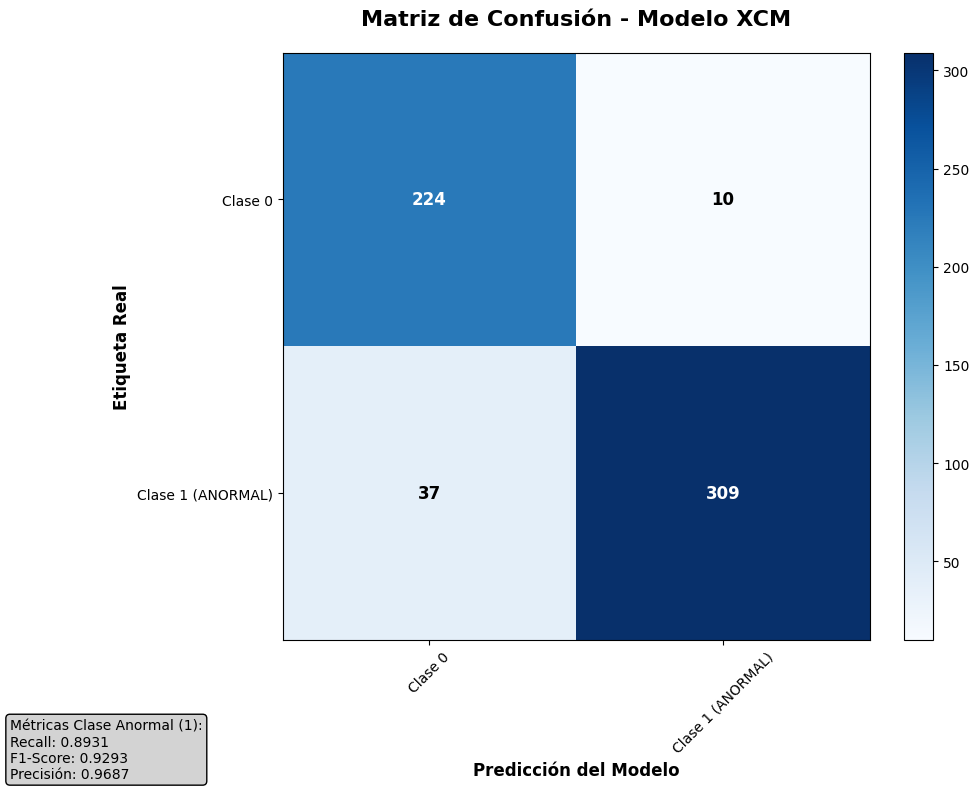


### Reporte de Clasificación del Modelo XCM ###
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       234
           1       0.97      0.89      0.93       346

    accuracy                           0.92       580
   macro avg       0.91      0.93      0.92       580
weighted avg       0.92      0.92      0.92       580


=== MÉTRICAS GLOBALES ===
Accuracy global: 0.9190
F1-Score macro: 0.9172
Recall macro: 0.9252

=== INFORMACIÓN CLASE ANORMAL (1) ===
Total muestras anormales en test: 346
Predichas como anormales: 319
Correctamente clasificadas como anormales: 309
Falsos positivos: 10
Falsos negativos: 37


In [20]:
from tsai.all import *
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np

# Entrenamiento y Evaluación del Modelo XCM

# 1. Crear los DataLoaders
dls = TSDataLoaders.from_numpy(X, y, splits=splits, bs=32)

# 2. Instanciar la arquitectura del modelo XCM
model = XCM(9, dls.c, seq_len=X.shape[2])

# 3. Crear el 'Learner'
learn = Learner(dls, model, metrics=[accuracy, F1Score(average='macro')])

# 4. Entrenar el modelo
print("Entrenando XCM con 50 epochs...")
learn.fit_one_cycle(50, lr_max=1e-3)

# 5. Evaluación final
test_dl = dls.test_dl(X[test_idx])
probas, _, preds = learn.get_preds(dl=test_dl, with_decoded=True)

preds_np = preds.numpy()
targets_np = y[test_idx]

clase_anormal = 1

print(f"Distribución de clases en test: {np.unique(targets_np, return_counts=True)}")
print(f"Clase anormal definida como: {clase_anormal}")

print(f"\n=== MÉTRICAS CLASE ANORMAL ({clase_anormal}) ===")
recall_anormal = recall_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]
f1_anormal = f1_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]
precision_anormal = precision_score(targets_np, preds_np, labels=[clase_anormal], average=None)[0]

print(f"Recall clase anormal: {recall_anormal:.4f}")
print(f"F1-Score clase anormal: {f1_anormal:.4f}")
print(f"Precisión clase anormal: {precision_anormal:.4f}")

print(f"\n=== MATRIZ DE CONFUSIÓN ===")
cm = confusion_matrix(targets_np, preds_np)
print("Matriz de confusión numérica:")
print(cm)

plt.figure(figsize=(10, 8))
im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Modelo XCM', fontsize=16, fontweight='bold', pad=20)
plt.colorbar(im, fraction=0.046, pad=0.04)

tick_marks = np.arange(len(np.unique(targets_np)))
class_labels = [f'Clase {i}' for i in range(len(np.unique(targets_np)))]
class_labels[clase_anormal] = f'Clase {clase_anormal} (ANORMAL)'

plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12,
                fontweight='bold')

plt.ylabel('Etiqueta Real', fontsize=12, fontweight='bold')
plt.xlabel('Predicción del Modelo', fontsize=12, fontweight='bold')
plt.tight_layout()

plt.figtext(0.02, 0.02,
           f"Métricas Clase Anormal ({clase_anormal}):\n"
           f"Recall: {recall_anormal:.4f}\n"
           f"F1-Score: {f1_anormal:.4f}\n"
           f"Precisión: {precision_anormal:.4f}",
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"),
           fontsize=10)

plt.show()

print("\n### Reporte de Clasificación del Modelo XCM ###")
print(classification_report(targets_np, preds_np))

print(f"\n=== MÉTRICAS GLOBALES ===")
accuracy_global = (targets_np == preds_np).mean()
print(f"Accuracy global: {accuracy_global:.4f}")

f1_macro = f1_score(targets_np, preds_np, average='macro')
print(f"F1-Score macro: {f1_macro:.4f}")

recall_macro = recall_score(targets_np, preds_np, average='macro')
print(f"Recall macro: {recall_macro:.4f}")

print(f"\n=== INFORMACIÓN CLASE ANORMAL ({clase_anormal}) ===")
total_anormal = (targets_np == clase_anormal).sum()
predichos_anormal = (preds_np == clase_anormal).sum()
correctos_anormal = ((targets_np == clase_anormal) & (preds_np == clase_anormal)).sum()

print(f"Total muestras anormales en test: {total_anormal}")
print(f"Predichas como anormales: {predichos_anormal}")
print(f"Correctamente clasificadas como anormales: {correctos_anormal}")
print(f"Falsos positivos: {predichos_anormal - correctos_anormal}")
print(f"Falsos negativos: {total_anormal - correctos_anormal}")

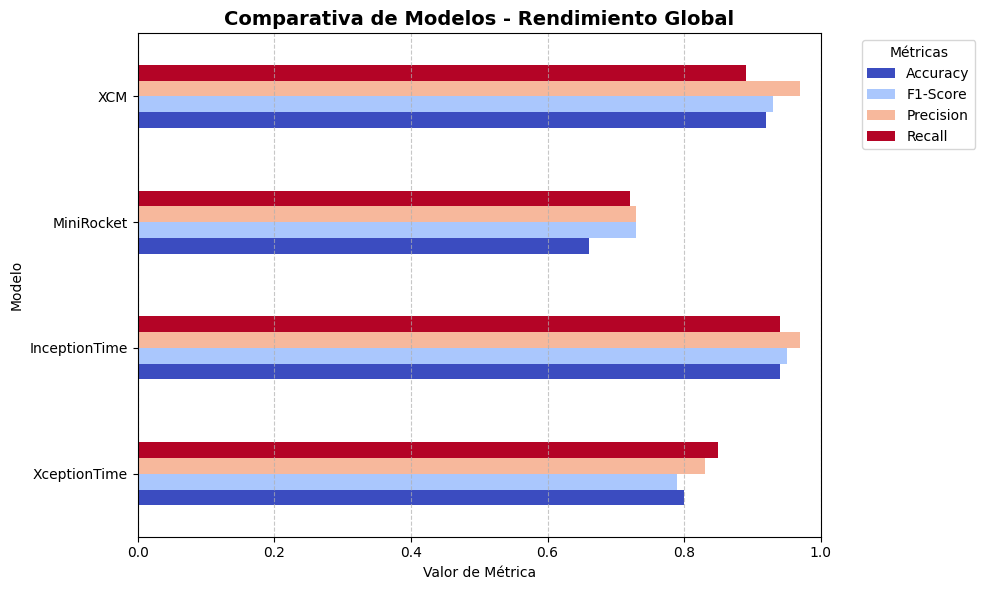

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Resultados de los modelos
data = {
    'Modelo': ['XceptionTime', 'InceptionTime', 'MiniRocket', 'XCM'],
    'Accuracy': [0.80, 0.94, 0.66, 0.92],
    'F1-Score': [0.79, 0.95, 0.73, 0.93],
    'Precision': [0.83, 0.97, 0.73, 0.97],
    'Recall': [0.85, 0.94, 0.72, 0.89]
}

df = pd.DataFrame(data)

df.set_index('Modelo')[['Accuracy','F1-Score','Precision','Recall']].plot(
    kind='barh', figsize=(10,6), colormap='coolwarm')

plt.title('Comparativa de Modelos - Rendimiento Global', fontsize=14, fontweight='bold')
plt.xlabel('Valor de Métrica')
plt.xlim(0, 1)
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
